In [ ]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering


In [ ]:
df=pd.read_excel("OnlineRetail.xlsx")

In [ ]:
#Q1'''Read and write a summary of the metadata .'''

'''
-This is an online retail dataset
-Dataset has 541,909 Invoices
-It has 8 columns InvoiceNo	StockCode Description Quantity InvoiceDate	UnitPrice CustomerID Country
-135080 transactions dont have a customer id
-Transaction timeframe is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00
'''

'\n-This is an online retail dataset\n-Dataset has 541,909 Invoices\n-It has 8 columns InvoiceNo\tStockCode Description Quantity InvoiceDate\tUnitPrice CustomerID Country\n-135080 transactions dont have a customer id\n-Transaction timeframe is from 2010-12-01 08:26:00 to 2011-12-09 12:50:00\n'

In [ ]:
df.isnull().mean()

InvoiceNo      0.000000
StockCode      0.000000
Description    0.002683
Quantity       0.000000
InvoiceDate    0.000000
UnitPrice      0.000000
CustomerID     0.249267
Country        0.000000
dtype: float64

In [ ]:
#Q2''' Select only the transactions that have occurred from 01/04/ 2011 and 09/12/2011 and create a dataset'''

df = df[pd.notnull(df['CustomerID'])]
df = df[df.Quantity > 0]
df = df[df.UnitPrice > 0]
df_1=df[df["InvoiceDate"].dt.year>=2011]
df_2=df_1[df_1["InvoiceDate"].dt.month>=4]
df_2 = df_2[df_2.Quantity > 0]
df_2 = df_2[df_2.UnitPrice > 0]
df_2

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
142083,548550,22662,LUNCH BAG DOLLY GIRL DESIGN,10,2011-04-01 08:22:00,1.65,18161.0,United Kingdom
142084,548550,22296,HEART IVORY TRELLIS LARGE,12,2011-04-01 08:22:00,1.65,18161.0,United Kingdom
142085,548550,21790,VINTAGE SNAP CARDS,12,2011-04-01 08:22:00,0.85,18161.0,United Kingdom
142086,548550,22622,BOX OF VINTAGE ALPHABET BLOCKS,2,2011-04-01 08:22:00,9.95,18161.0,United Kingdom
142087,548550,22393,PAPERWEIGHT VINTAGE COLLAGE,6,2011-04-01 08:22:00,2.55,18161.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [ ]:
df_2.isnull().mean()

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [ ]:
##Q3
df_recency = df_2.groupby(by='CustomerID',
                        as_index=False)['InvoiceDate'].max()
df_recency.columns = ['CustomerID', 'LastPurchaseDate']
recent_date = df_recency['LastPurchaseDate'].max()
df_recency['Recency'] = df_recency['LastPurchaseDate'].apply(
    lambda x: (recent_date - x).days)
df_recency.head()

,CustomerID,LastPurchaseDate,Recency
0,12347.0,2011-12-07 15:52:00,1
1,12348.0,2011-09-25 13:13:00,74
2,12349.0,2011-11-21 09:51:00,18
3,12352.0,2011-11-03 14:37:00,35
4,12353.0,2011-05-19 17:47:00,203


In [ ]:
frequency_df = df.drop_duplicates().groupby(
    by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_df.columns = ['CustomerID', 'Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:

df['Total'] = df['UnitPrice']*df['Quantity']
monetary_df = df.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerID', 'Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
rf_df = df_recency.merge(frequency_df, on='CustomerID')
rfm_df = rf_df.merge(monetary_df, on='CustomerID').drop(
    columns='LastPurchaseDate')
rfm_df.head()

,CustomerID,Recency,Frequency,Monetary
0,12347.0,1,182,4310.00
1,12348.0,74,31,1797.24
2,12349.0,18,73,1757.55
3,12352.0,35,85,2506.04
4,12353.0,203,4,89.00


In [ ]:
quantiles = rfm_df.quantile(q=[0.25,0.50,0.75])
quantiles = quantiles.to_dict()

In [ ]:
segmented_rfm = rfm_df.copy()

In [ ]:
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
segmented_rfm['R_quartile'] = segmented_rfm['Recency'].apply(RScore, args=('Recency',quantiles))
segmented_rfm['F_quartile'] = segmented_rfm['Frequency'].apply(FMScore, args=('Frequency',quantiles))
segmented_rfm['M_quartile'] = segmented_rfm['Monetary'].apply(FMScore, args=('Monetary',quantiles))
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile
0,12347.0,1,182,4310.00,1,1,1
1,12348.0,74,31,1797.24,3,3,2
2,12349.0,18,73,1757.55,2,2,2
3,12352.0,35,85,2506.04,2,2,1
4,12353.0,203,4,89.00,4,4,4


In [ ]:
segmented_rfm['RFM_Segment'] = segmented_rfm.R_quartile.map(str)+segmented_rfm.F_quartile.map(str)+segmented_rfm.M_quartile.map(str)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment
0,12347.0,1,182,4310.00,1,1,1,111
1,12348.0,74,31,1797.24,3,3,2,332
2,12349.0,18,73,1757.55,2,2,2,222
3,12352.0,35,85,2506.04,2,2,1,221
4,12353.0,203,4,89.00,4,4,4,444


In [ ]:
segmented_rfm['RFM_Score'] = segmented_rfm[['R_quartile','F_quartile','M_quartile']].sum(axis=1)
segmented_rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_quartile,F_quartile,M_quartile,RFM_Segment,RFM_Score
0,12347.0,1,182,4310.00,1,1,1,111,3
1,12348.0,74,31,1797.24,3,3,2,332,8
2,12349.0,18,73,1757.55,2,2,2,222,6
3,12352.0,35,85,2506.04,2,2,1,221,5
4,12353.0,203,4,89.00,4,4,4,444,12


In [ ]:
segmented_rfm.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count'] }).round(1)

Recency Frequency Monetary      
             mean      mean     mean count
RFM_Score                                 
3             5.3     401.6  10343.1   377
4            16.7     205.2   4422.2   348
5            27.0     122.8   2467.5   367
6            36.5      91.9   2020.8   377
7            47.5      64.2   1164.2   394
8            66.9      48.0    873.1   447
9            66.1      30.9    762.8   437
10           97.0      22.5    417.5   467
11          113.3      15.3    276.4   326
12          177.5       9.7    188.8   309

In [ ]:
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.histplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

In [ ]:
df_rfm_log = rfm_df.copy()

Recency's: Skew: -0.6319569882408304, : SkewtestResult(statistic=-14.763508608869413, pvalue=2.518314875845056e-49)
Frequency's: Skew: -0.0559214223790976, : SkewtestResult(statistic=-1.4180157372255786, pvalue=0.15618617025101994)
Monetary's: Skew: 0.35291900693595724, : SkewtestResult(statistic=8.699662778405349, pvalue=3.3287185793219543e-18)


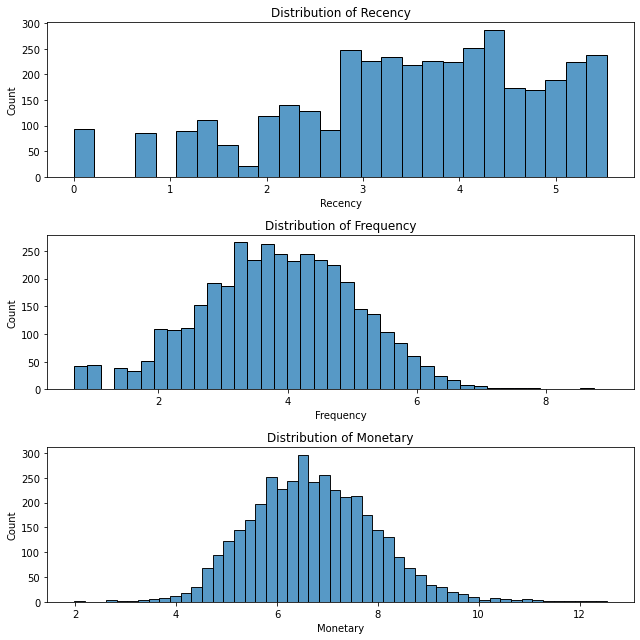

In [ ]:
df_rfm_log = np.log(df_rfm_log+1)

plt.figure(figsize=(9, 9))

plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')

plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')

plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')

plt.tight_layout()
plt.savefig('after_transform.png', format='png', dpi=1000)

In [ ]:
##Q14 and Q15
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df_rfm_log) 
    kmeanModel.fit(df_rfm_log)     
      
    distortions.append(sum(np.min(cdist(df_rfm_log, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_rfm_log.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_rfm_log, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df_rfm_log.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

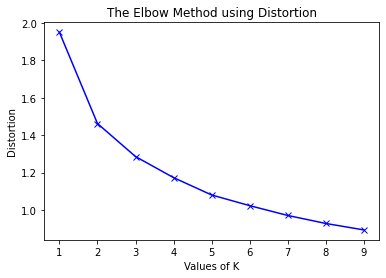

In [ ]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

<AxesSubplot:>

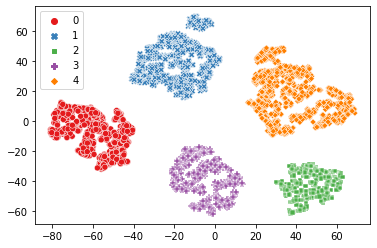

In [ ]:
#Q16
kmeans = KMeans(n_clusters = 5, random_state = 1)
kmeans.fit(df_rfm_log)

cluster_labels = kmeans.labels_
        
df_new = df_rfm_log.assign(Cluster = cluster_labels)
    

model = TSNE(random_state=1)
transformed = model.fit_transform(df_new)

sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")


In [ ]:
#Q17
centers = kmeans.cluster_centers_
print(centers)

[[9.64449395 4.42100885 2.21601538 5.21193591]
 [9.6237176  3.55490085 4.83028668 7.63509829]
 [9.621113   1.45569039 5.44247065 8.46353403]
 [9.63134974 2.37578732 3.62903234 6.3571686 ]
 [9.62734421 4.54260309 3.60261292 6.43735769]]


In [ ]:
#Q18
ac5 = AgglomerativeClustering(n_clusters = 5)

In [ ]:
'''Visualize the clusters using the dendrogram.'''